# Are you mad enough to sell more clothes?

<img src="https://tablet-mag-images.b-cdn.net/production/458696ee8cc3614bf3014fc487f2ad4c33d1ca62-620x416.jpg?w=1200&q=70&auto=format&dpr=1"/>

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val,mode="mask", reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    """
    Classification made simple (or is it more complex?)
    THIS WORKS FOR 2 Class Classification problems only
    parameters: parameter grid in the sklearn style
    indf: dataframe you feed in
    featurenames: list of columnames corresponding to features you want in your model
    targetname: the column you want to use as target
    target1val: the value of the "targetname" column
    mode: mask or split. mask a boolean mask to choose train/test or
        split a dictionary with keys Xtrain/Xtest/ytrain/ytest and values existing
        training and test sets in the canonical form
    reuse_split: the actual mask above or the actuall ditionary, depending upon which
        modu you chose
    score_func: this is from GridSearchCV
    n_folds: cross val folds
    n_jobs: mumber of processes to use in cross-validation
    
    We return classifier, and the train and test sets. We print accuracies
    and the confusion matrix
    """
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mode=="mask":
        print("using mask")
        mask=reuse_split
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    else:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest

The data set is from a fairly high end clothing chain store in the North East.

You are a data analyst for this store. Your job is to write a report to the pointy-haired boss in which you show how you can increase the store's profit by being targeted about whom to send a catalog in the mail. Yes, you are in direct marketing. You are a quant amongst the "mad men". 

You need to explore and layout in simple terms, what the business needs to spend to increase its profit. In other words, you need a budget, and its your job to figure out how much as well.

We'll guide you through the process. There is much more you can explore, of-course, but this homework will walk you through an entire real world classification and analysis process with a finite amount of work and computer runtime.

You will

1. clean the data, and create some features, learning about how to standardize the data
2. write a classifier on this data, including cross validation, and learn to write a function to encapsulate this process
3. learn how to compare this classifier to baseline classifiers that you better beat using a profit metric rather than an accuracy metric
4. understand and use prediction thresholds
5. understand the use a ROC curve, especially in the situation where probability thresholds are not possible
6. learn to use a profit curve to pick a model, thus directly reflecting the metric of importance
7. learn a bit about feature selection, and why we need to pipeline feature selection and classification together, in an attempt to improve a classifier
8. balance a data set to improve the performance of a SVM classifier
9. implement a kernelized SVM to improve performance further.
10. make a final comparison of classifiers and make a presentation for your boss.

This homework is long because we are walking you through the entire process, start early! There are some parts of it that can be solved by understanding, copying, and slightly modifying code from the lab.  Feel free to do that. Pay attention to any difference in signature in the lab functions to the ones here.

The idea for this homework, and the attendant data set is taken from the book "Data Mining Methods and Models" by [Larose](http://www.dataminingconsultant.com/DMMM.htm). Henceforth we refer to this book as DMMM. There is an analysis of the data set there as well (ch7, the book is available online through our library), which you might be interested in. It is far more detailed than this homework, talking about log-normal data transformations, amongst other things.

(Image credit: www.tabletmag.com)

(This documentation of the fields is taken verbatim from DMMM).

The clothing-store data set contains information about 28,799 customers in the following 51 fields:

- Customer ID: unique, encrypted customer identification `HHKEY`
- Zip code `ZIP_CODE`
- Number of purchase visits `FRE`
- Total net sales `MON`
- Average amount spent per visit `AVRG`
- Amount spent at each of four different franchises (four variables) `AMSPEND`, `PSSPEND`, `CCSPEND`, `AXSPEND`
- Amount spent in the past month, the past three months, and the past six months `OMONSPEND`, `TMONSPEND`, `SMONSPEND`
- Amount spent the same period last year `PREVPD`
- Gross margin percentage `GMP`
- Number of marketing promotions on file `PROMOS`
- Number of days the customer has been on file `DAYS`
- Number of days between purchases `FREDAYS`
- Markdown percentage on customer purchases `MARKDOWN`
- Number of different product classes purchased `CLASSES`
- Number of coupons used by the customer `COUPONS`
- Total number of individual items purchased by the customer `STYLES`
- Number of stores the customer shopped at `STORES`
- Number of promotions mailed in the past year `MAILED`
- Number of promotions responded to in the past year `RESPONDED`
- Promotion response rate for the past year `RESPONSERATE`
- Product uniformity (low score = diverse spending patterns) `HI`
- Lifetime average time between visits `LTFREDAYS`
- Microvision lifestyle cluster type `CLUSTYPE`
- Percent of returns `PERCRET`
- Flag: credit card user `CC_CARD`
- Flag: valid phone number on file `VALPHON`
- Flag: Web shopper `WEB`
- 15 variables providing the percentages spent by the customer on specific classes of clothing, including sweaters, knit tops, knit dresses, blouses, jackets, career pants, casual pants, shirts, dresses, suits, outerwear, jewelry, fashion, legwear, and the collectibles line; (`P*`, `PJACKETS` for example) also a variable showing the brand of choice (encrypted)
- **Target variable**: response to promotion `RESP`...this is our **response** or **y**.


These data are based on a direct mail marketing campaign conducted last year. We want to use this information to develop classification models for this year’s marketing campaign.

## Features and a simple classifier

### Get, check, clean,  the data

In [3]:
df=pd.read_csv("./data/Clothing_Store.csv")
df.head()

,HHKEY,ZIP_CODE,REC,FRE,MON,CC_CARD,AVRG,PC_CALC20,PSWEATERS,PKNIT_TOPS,...,VALPHON,WEB,MAILED,RESPONDED,RESPONSERATE,HI,LTFREDAY,CLUSTYPE,PERCRET,RESP
0,9955600066402,1001,208,2,368.46,0,184.23,11,0.18,0.00,...,N,0,5,0,0.00,31.81,111.00,10,0.00,0
1,9955600073501,1028,6,4,258.00,1,64.50,11,0.26,0.16,...,Y,0,4,2,50.00,32.72,43.50,10,0.03,1
2,9955600076313,1056,327,2,77.00,0,38.50,11,1.00,0.00,...,N,0,4,0,0.00,100.00,68.60,16,0.00,0
3,9955600078045,1118,66,8,846.06,1,105.75,11,0.38,0.00,...,Y,0,9,6,66.67,23.27,26.96,10,0.00,0
4,9955600078517,1107,49,1,87.44,0,87.44,11,0.20,0.20,...,Y,0,0,0,0.00,28.52,24.50,20,0.00,0


In [4]:
df.shape

(21740, 51)

We'll delete some columns we dont intend to use, and which I couldnt quite figure out what they were from the original data set and documentation.

In [5]:
del df['CLUSTYPE']
del df['HHKEY'], df['ZIP_CODE'], df['REC'], df['PC_CALC20'] 
del df['STORELOY']

In [6]:
df.columns

Index(['FRE', 'MON', 'CC_CARD', 'AVRG', 'PSWEATERS', 'PKNIT_TOPS',
       'PKNIT_DRES', 'PBLOUSES', 'PJACKETS', 'PCAR_PNTS', 'PCAS_PNTS',
       'PSHIRTS', 'PDRESSES', 'PSUITS', 'POUTERWEAR', 'PJEWELRY', 'PFASHION',
       'PLEGWEAR', 'PCOLLSPND', 'AMSPEND', 'PSSPEND', 'CCSPEND', 'AXSPEND',
       'TMONSPEND', 'OMONSPEND', 'SMONSPEND', 'PREVPD', 'GMP', 'PROMOS',
       'DAYS', 'FREDAYS', 'MARKDOWN', 'CLASSES', 'COUPONS', 'STYLES', 'STORES',
       'VALPHON', 'WEB', 'MAILED', 'RESPONDED', 'RESPONSERATE', 'HI',
       'LTFREDAY', 'PERCRET', 'RESP'],
      dtype='object')

Make a copy of the dataframe to make transformations to.

In [7]:
dftouse=df.copy()

### Feature Engineering

Feature Engineering is one of the most important "human inputs" that go into machine learning. Machines can run algorithms, but if you feed in garbage, you will get out garbage. The features that are important, or the feature combinations that might be useful in a problem, are inputs that humans can use to help the machine along. Domain knowledge is particularly useful. 

We first list the columns that are percentages:

In [8]:
PERCENT_VARS=[ u'PSWEATERS', u'PKNIT_TOPS', u'PKNIT_DRES', u'PBLOUSES', u'PJACKETS', u'PCAR_PNTS', u'PCAS_PNTS', u'PSHIRTS', 
              u'PDRESSES', u'PSUITS', u'POUTERWEAR', u'PJEWELRY', u'PFASHION', u'PLEGWEAR', u'PCOLLSPND']
len(PERCENT_VARS)

15

Next, we look for columns where the existence or lack thereof of a zero may be important in a classifier. We used our intuition to make these choices, believing that there is additional information encoded in say, `PERCRET`: if you never returned anything you might not be a budget shopper and thus someone who might have the money to shop quite a bit...

In [9]:
ZERO_IMPORTANT_VARS = [u'PREVPD', u'AMSPEND', u'PSSPEND', u'CCSPEND', u'AXSPEND', u'RESPONDED', u'PERCRET']

We also list the columns with floating-point or integer variables that are amenable to standardization

In [10]:
STANDARDIZABLE = PERCENT_VARS + ZERO_IMPORTANT_VARS + [u'FRE', u'MON',  u'AVRG', u'GMP', u'PROMOS', u'DAYS', u'FREDAYS', u'MARKDOWN', u'CLASSES', u'COUPONS', u'STYLES',  u'MAILED',  u'RESPONSERATE', u'HI', u'LTFREDAY']

Now, an **indicator variable** is one which takes a few, usually 2 values (1/0, True/False) to code the existence or lack thereof of a property or feature. We look for existing indicators:

#### Zero important indicators

We encode VALPHON, PERCENT_VARS, and ZERO_IMPORTANT_VARS as indicators. By doing this we are saying: the fact that these features are non-zero carries additional importance as compared to their values.

We maintain a global list INDICATORS in which the names of these columns are stored, prepending an `i_` to each of these variables to denote that they are indicators.

Note that all changes are now being made to the `dftouse` dataframe.

In [11]:
# rename some indicators and make them all 1-0
dftouse['i_VALPHON']=(df.VALPHON=='Y')*1
del dftouse['VALPHON']
dftouse.rename(columns={'WEB':'i_WEB', 'CC_CARD':'i_CC_CARD'}, inplace=True)
INDICATORS=['i_VALPHON','i_WEB','i_CC_CARD']

We then take the `ZERO_IMPORTANT_VARS`, the ones we thought where presence or absence was important, and create indicators from them

In [12]:
for p in ZERO_IMPORTANT_VARS:
    dftouse['i_'+p]=(df[p] > 0.0)*1
    INDICATORS.append('i_'+p)

And then we create indicators for each of the percent variables `PERCENT_VARS` (following Larose's ch7), in the hope that the presence or absence of buying a particular clothing style such as blouses makes a difference...

In [13]:
for p in PERCENT_VARS:
    dftouse['i_'+p]=(df[p] > 0.0)*1
    INDICATORS.append('i_'+p)

#### Combine some features 

We do this to communicate clearly information about recentness and savings

We add two more indicators corresponding to recent spending, and recent use of a savings mechanism.

In [14]:
#create recent usage (1 month and 3 month),  sale-shopper (markdown+coupon)
dftouse["i_RECENT"]=1*((df.OMONSPEND > 0) | (df.TMONSPEND > 0))
dftouse["i_SAVER"]=1*((df.MARKDOWN > 0) | (df.COUPONS > 0))
INDICATORS.append("i_RECENT")
INDICATORS.append("i_SAVER")

Lets see what we now have...

In [15]:
dftouse.head()

,FRE,MON,i_CC_CARD,AVRG,PSWEATERS,PKNIT_TOPS,PKNIT_DRES,PBLOUSES,PJACKETS,PCAR_PNTS,...,i_PSHIRTS,i_PDRESSES,i_PSUITS,i_POUTERWEAR,i_PJEWELRY,i_PFASHION,i_PLEGWEAR,i_PCOLLSPND,i_RECENT,i_SAVER
0,2,368.46,0,184.23,0.18,0.00,0.00,0.30,0.0,0.25,...,1,0,0,0,0,1,1,1,0,1
1,4,258.00,1,64.50,0.26,0.16,0.00,0.00,0.0,0.18,...,0,1,0,0,0,0,1,1,1,1
2,2,77.00,0,38.50,1.00,0.00,0.00,0.00,0.0,0.00,...,0,0,0,0,0,0,0,0,0,1
3,8,846.06,1,105.75,0.38,0.00,0.05,0.06,0.2,0.17,...,1,0,0,0,1,1,1,0,1,1
4,1,87.44,0,87.44,0.20,0.20,0.00,0.00,0.0,0.00,...,0,0,0,0,1,0,0,0,1,1


In [16]:
dftouse.shape

(21740, 69)

Clearly we've currently expanded the number of features we have in an attempt to pit in information in the form of indicators which communicate additional distinguishing (in our opinion).

### Test and Training Sets, and Standardization

We standardize test and training sets separately. Specifically, we wish to standardize the non-indicator columns on both the test and training sets, by subtracting out the mean of the training set from the value, and dividing by the standard deviation of the training set. This helps us put all the continuous variables on the same scale.

(There is another reason this might be useful. One optimization which we dont do in this homework but which is useful is to take the log of all positive continuous variables. This makes data look more "normal" which can be useful in some algorithms, and then such standardization can basically be thought of in units of standard deviations of the normal distribution)

#### Q1. Why do we do this standardization on the two sets separately?

(Hint: what happens to the purity of the training data if we standardize using the entire dataset?)

Standardizing the entire dataset before splitting into training and test sets can lead to data leakage. This occurs because the standardization parameters are computed using the entire dataset, including the test data. As a result, the training data gains information about the test set, compromising the model's ability to generalize to new, unseen data.

values of the (colums - mean) devided by strandard divination
why my data is pure and how standard deviation entire data set


We'll split the dataset and create a training and test mask.

In [17]:
from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(dftouse.shape[0]), train_size=0.7, random_state=1983)

In [18]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [19]:
mask

array([ True,  True,  True, ..., False,  True,  True])

In [20]:
mask.shape, mask.sum()

((21740,), 15217)

In [21]:
dftrain = df[mask]
dftest = df[~mask]

#### Q2. Explain how a mask is used above to split the data into training and test sets?

When you use a mask to split your data, you designate specific entries as belonging either to the training set or to the test set. This mask is strictly adhered to throughout the model training and validation process. By doing this, you ensure that there's no overlap or exchange of information between the two datasets. The training process remains completely blind to the makeup of the test set.

#### We'll standardize the data

We'll use `StandardScaler` from `sklearn.preprocessing` to "fit" the columns in `STANDRARDIZABLE` on the training set. Then use the resultant estimator to transform both the training and the test parts of each of the columns in the dataframe, replacing the old unstandardized values in the `STANDARDIZABLE` columns of `dftouse` by the new standardized ones.

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
scaler = StandardScaler().fit(dftrain[STANDARDIZABLE].values)



In [24]:
scaler.mean_

array([2.14004977e-01, 2.65025278e-02, 4.24038499e-02, 9.29793098e-02,
       1.35212043e-01, 8.63539111e-02, 6.88694360e-02, 6.61740783e-02,
       6.86499190e-02, 3.45040401e-02, 1.82938688e-02, 9.85452704e-03,
       2.94535562e-02, 1.29327569e-02, 7.39101853e-02, 4.18878320e+01,
       1.46349188e+01, 1.47963305e+02, 2.90272421e+02, 2.36873076e+01,
       1.20365381e+00, 1.30640754e-01, 5.08911086e+00, 4.76318585e+02,
       1.13993882e+02, 5.23920086e-01, 1.15831636e+01, 4.37386476e+02,
       1.70586566e+02, 1.86756618e-01, 7.14155221e+00, 7.52119340e-01,
       1.72235000e+01, 4.67030295e+00, 1.74466925e+01, 3.81165414e+01,
       8.01916317e+01])

In [25]:
scaler

StandardScaler()

In [26]:
outtrain=scaler.transform(dftrain[STANDARDIZABLE].values)
outtest=scaler.transform(dftest[STANDARDIZABLE].values)

In [27]:
dftouse.loc[mask, STANDARDIZABLE] = outtrain
dftouse.loc[~mask, STANDARDIZABLE] = outtest

/var/folders/77/hjls9y4x3pn_d_lx26chmphm0000gn/T/ipykernel_8736/260851812.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.65235648  0.43160384 -0.65235648 ...  0.43160384 -0.65235648
  0.43160384]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dftouse.loc[mask, STANDARDIZABLE] = outtrain
/var/folders/77/hjls9y4x3pn_d_lx26chmphm0000gn/T/ipykernel_8736/260851812.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.47970091 -0.16912552 -0.47970091 ...  0.14144988 -0.32441322
 -0.01383782]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dftouse.loc[mask, STANDARDIZABLE] = outtrain
/var/folders/77/hjls9y4x3pn_d_lx26chmphm0000gn/T/ipykernel_8736/260851812.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and wil

We create a list `lcols` of the columns we will use in our classifier. This list should not contain the response `RESP`. How many features do we have?

In [28]:
lcols=list(dftouse.columns)
lcols.remove(u'RESP')
len(lcols)

68

### Writing code for a classifier

We will now take this data and write a classifier to predict the response, which is in the `RESP` column of `dftouse`. This response corresponds to asking the question: will a user targeted with our advertisement respond or not?

#### Train a Logistic Regression on this data.

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
params = {"C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
clflog, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(solver="liblinear"), params, dftouse,lcols, u'RESP',1,  mode="mask", reuse_split=mask)

using mask
BEST {'C': 0.1} 0.84990499727299
############# based on standard predict ################
Accuracy on training data: 0.85
Accuracy on test data:     0.86
[[5352  103]
 [ 834  234]]
########################################################


We will create a dictionary of the used train and test set both on the features and target to reuse for later:

In [31]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

## Estimate costs and benefits from assumptions and data

### Our data is highly asymmetric

First notice that our data set is very highly asymmetric, with positive `RESP`onses only making up 16-17% of the samples.

In [32]:
print("whole data set", dftouse['RESP'].mean())#Highly asymmetric
print("training set", dftouse['RESP'][mask].mean(), "test set", dftouse['RESP'][~mask].mean())

whole data set 0.16609935602575898
training set 0.16711572583294998 test set 0.16372834585313506


This means that a classifier which predicts that EVERY customer is a negative has an accuracy rate of 83-84%. By this we mean that **a classifier that predicts that no customer will respond to our mailing** has an accuracy of 83-84%!

#### Compare the accuracy of the Logisic Regression to the no-customer-responds baseline

Based on your comparison, and using accuracy as a metric, does the classifier seem worthwhile pursuing?

Technically yes, its marginally better than the baseline of assuming that no-customer comes back...

But we havent asked the most important question. Is accuracy really the relevant metric?

### Costs and the Confusion Matrix

Our classifier above had, as one of its printed outputs, a confusion matrix. It looked like this:

In [33]:
ypred=clflog.predict(Xtest)
confusion_matrix(ytest, ypred)

array([[5352,  103],
       [ 834,  234]])

The matrix above is of this form:

![hwimages](./images/confusionmatrix.png)


**Important note**: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`

In our example, +ives (those with a 1 `RESP`onse) are people who respond to the mailing by going into the store and buying goods. These are also called observed positives (OP). And -ives (those with a 0 `RESP`onse) are those who do not respond to the mailing. These are also called observed Negatives. On our test set, we can print the observed positives and observed negatives respectively:

In [34]:
print("OP=", ytest.sum(), ", ON=",ytest.shape[0] - ytest.sum())

OP= 1068 , ON= 5455


We can make a similar calculation on the predictions of our LR classifier made on the test set. This gives us the predicted negatives (PN): those customers who we predict will not respond to our mailing; and the predicted positives (PP), the customers who we predict will respond to our mailing by coming into the store to buy stuff.

In [35]:
print("PP=", ypred.sum(), ", PN=",ytest.shape[0] - ypred.sum())

PP= 337 , PN= 6186


In addition to these four quantities, the confusion matrix gives us more details on proper classifications and mis-classifications from our classifier:

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP). These are folks we correctly identified as responders,and thus sending them a mailing would result in a sale for us. True Positives are great. We do incur the cost of mailing them, but we like to because they will come into the store to buy.
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP). False Positives incur us the cost of mailing them as well, but are not very costly. These are people who wouldnt have responded, but we sent them a mailing because our classifier mispredicted them as buyers. Thus, for them, we only incur the cost of preparing the mailing and mailing it to them.
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN). These are folks we correctly identified as not-responding, and thus we dont waste any money on sending them a mailing. This is a great classification for us.
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN). False negatives are VERY costly: these are folks who would have responded to us had we mailed them, but we didnt target them, leading to huge lost sales per person. Notice that our SVM classifier has tons of False Negatives

It is not enough to simply identify these categories from the confusion matrix. Rather, we want to sit down with our business team and identify the costs associated with each of the 4 classification situations above. Keep in mind that these costs might even change from year to year or even more suddenly: this is why it is important to have marketing and sales people on your data science teams. (See Patil, D. J. Building data science teams. " O'Reilly Media, Inc.", 2011.
 for more details).
 
 Fortunately you have talked to your domain experts and done just that!

#### Costs for True Positives, False Negatives, False Positives, and True Negatives

Lets categorize the costs for each one of these alternatives.

Lets assume the amortized cost of preparing a mailing and mailing it is \$3. Lets assume additionally that the profit margin on a sale is 30% (we are a high end clothing chain).

True Negatives cost us nothing but gain us nothing either.

In [36]:
tnc=0.0 #tnr stands for "true negative cost"

From the average cost of a sale, and the 30% profit assumption, we calculate `tpc`, the cost of a true positive. Note: `tpc` must be negative, since we are talking about costs.

The `tpc` takes into account the cost of mailing to the respondent, and since our mailing works, we subtract out the profit. We use the average of the `AVRG` column, which is the average money spent by a customer on each visit.

In [37]:
dftrain.AVRG.mean(), dftrain.FRE.mean()

(113.99388249983572, 5.089110862850759)

In [38]:
prep_and_mail=3
coupon = 15
profit_margin=0.3
tpc=prep_and_mail + coupon - np.mean(dftrain.AVRG)*profit_margin
tpc

-16.198164749950713

The false negative is a lost sale for us! We didnt mail them, and they didnt spend the money. They would have if we mailed them. So we lost a certain profit per such false negative! Thus the false-negative cost, given by `fnc`, is:

In [39]:
fnc = 2*np.mean(dftrain.AVRG)*profit_margin
fnc

68.39632949990143

This leaves us with False positives. This is a person who would not have responded but you wasted $3 on. So the false positive cost, (`fpc`) is:

In [40]:
fpc=prep_and_mail
fpc

3

#### Cost  and Utility Matrix

We then use these costs to write a **risk or cost matrix** in the same form as the confusion matrix above. 

![cost matrix](images/costmatrix.png)

In [41]:
risk_matrix=np.array([[tnc, fpc],[fnc, tpc]])
risk_matrix

array([[  0.        ,   3.        ],
       [ 68.3963295 , -16.19816475]])

Notice that the cost of a false positive is 11 times less than the cost of a false negative. As is often the case in situations in which one class dominates the other, the costs of one kind of misclassification: false negatives are differently expensive than false positives. We saw above that FN are more costly in our case than FP. Similar situations arise in cancer prediction, for example, where a FP only means that you diagnosed a healthy person with cancer, but a FN means that you misdiagnosed a cancer patient as healthy: possibly killing them in the process!

The negative of the cost matrix is called the **utility matrix or profit matrix** `u`. Here we calculate this utility matrix, which we shall use in the next part of the homework.

In [42]:
u = - risk_matrix
u

array([[ -0.        ,  -3.        ],
       [-68.3963295 ,  16.19816475]])

Ok! Now we can use this profit matrix to calculate the profit that the SVM classifier can land us. 

#### Average Profit Per Person

We can compute the average profit per person using the following formula, which calculates the "expected value" of the per-customer profit (the $P$ below stands for "predicted" and $O$ for observed):



\begin{eqnarray}
Profit &=& u(+P,+O) \times p(+P,+O) \\
       &+& u(+P,-O) \times p(+P,-O) \\
       &+& u(-P,+O) \times p(-P,+O) \\
       &+& u(-P,-O) \times p(-P,-O) 
\end{eqnarray}


which gives


$$ Profit =  \frac{( TP \times -TPC )+ ( FP \times -FPC ) + ( FN \times -FNC ) + ( TN \times -TNC )}{N}$$

where N is the total size of the test set, +P means predicted positive, -O is observed negative, and so on and so forth. The formula above just weighs the profit of a combination of observed and predicted with the out-of-sample probability of the combination occurring. The probabilities are "estimated" by the corresponding confusion matrix on the **test set**, which leads to the second formula. $-TPC$ is just the 'true positive' utility (similar for the others...).

The profit can thus be found by multiplying the utility matrix by the confusion matrix elementwise, and dividing by the sum of the elements in the confusion matrix, or the test set size.

We implement this process of finding the average profit per person in the `average_profit_pp` function below:

In [43]:
def average_profit_pp(y, ypred, u):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*u)/np.sum(c)
    return score

But before we make this calculation for our logistic classifier, we need to first check what profit or cost our baseline classifier which assumes that no customer will respond, incurs.

### Establishing Baseline Classifiers via profit

The simplest classifiers you can think of are the "send to everyone" and "dont send to everyone" classifiers. We explain these below. If we are going to write any more complex classifiers we should at-least outperform these.



#### Dont Send to Anyone Baseline Classifier 

This is the "majority" classifier we talked about earlier. We dont send mailings to anyone because we believe that **no-one will respond**. Thus this classifier predicts everyone to be a 0 or -ive, a non-respondent. Remember, this classifier has a 83-84% accuracy.

We write a confusion matrix `dste` for the "dont send to everyone" model (not the best acronym, I know!), and calculate the average profit per person as `dsteval`. 

In [44]:
testsize = dftouse[~mask].shape[0]
ypred_dste = np.zeros(testsize, dtype="int")
print(confusion_matrix(ytest, ypred_dste))
dsteval = average_profit_pp(ytest, ypred_dste, u)
dsteval

[[5455    0]
 [1068    0]]


-11.198417891444846

#### Send to Everyone Baseline Classifier

This is the other extreme. In this case we **predict everyone as responders** and send the mailing to everyone. In other words, we predict everyone on the test set to be a 1. Print out both the confusion matrix and `steval`, the average profit per person, for this case. Based on this result, which one of these two classifiers is the one to beat? Why?

In [45]:
# Assuming dftouse and mask are already defined as per your earlier code
testsize = dftouse[~mask].shape[0]
# Create an array where every prediction is 1 (everyone is predicted to respond)
ypred_dste_all = np.ones(testsize, dtype="int")

# Print the confusion matrix for this scenario
print("Confusion Matrix for 'Send to Everyone' Baseline Classifier:")
print(confusion_matrix(ytest, ypred_dste_all))

# Calculate average profit per person for sending to everyone
dsteval_all = average_profit_pp(ytest, ypred_dste_all, u)  # 'u' should be defined as the unit profit per positive response
print("Average Profit Per Person:", dsteval_all)



Confusion Matrix for 'Send to Everyone' Baseline Classifier:
[[   0 5455]
 [   0 1068]]
Average Profit Per Person: 0.1432837579253963


#### Q3: Compare the Logistic Regression classifier with these baselines

Using the  classifier we calculated, `clflog` and its predictions `ypred`, calculate the profit we can make

In [46]:
#code
average_profit_pp(ytest, ypred, u)

-8.211124981056159

If you did this correctly, at this point you might be a bit dejected....

#### Q4: Implement logistic regression with Lasso based feature selection

We run another classifier, a logistic regression with L1 regularization, using the `do_classify` function we defined above. L1 or Lasso regularization automatically does feature selection for us!

Return as the estimator `clflog_lasso`, and training and test sets `Xtrain`, `ytrain`, `Xtest`, and `ytest`. Let the regularization hyperparameter `C` range in powers of 10 from 0.001 to 100. Use the `reuse_split` dictionary we calculated earlier. Remember that we want to use "L1" or Lasso regularization: you can do this by passing `penalty="l1"` to the Logistic Regression: `LogisticRegression(penalty="l1")`.

Use `mode="not mask", reuse_split=reuse_split, solver='liblinear'` as additional arguments. The `reuse_split` argument makes sure that we are comparing the two classifiers on the same training and test sets.

In [47]:
lcols

['FRE',
 'MON',
 'i_CC_CARD',
 'AVRG',
 'PSWEATERS',
 'PKNIT_TOPS',
 'PKNIT_DRES',
 'PBLOUSES',
 'PJACKETS',
 'PCAR_PNTS',
 'PCAS_PNTS',
 'PSHIRTS',
 'PDRESSES',
 'PSUITS',
 'POUTERWEAR',
 'PJEWELRY',
 'PFASHION',
 'PLEGWEAR',
 'PCOLLSPND',
 'AMSPEND',
 'PSSPEND',
 'CCSPEND',
 'AXSPEND',
 'TMONSPEND',
 'OMONSPEND',
 'SMONSPEND',
 'PREVPD',
 'GMP',
 'PROMOS',
 'DAYS',
 'FREDAYS',
 'MARKDOWN',
 'CLASSES',
 'COUPONS',
 'STYLES',
 'STORES',
 'i_WEB',
 'MAILED',
 'RESPONDED',
 'RESPONSERATE',
 'HI',
 'LTFREDAY',
 'PERCRET',
 'i_VALPHON',
 'i_PREVPD',
 'i_AMSPEND',
 'i_PSSPEND',
 'i_CCSPEND',
 'i_AXSPEND',
 'i_RESPONDED',
 'i_PERCRET',
 'i_PSWEATERS',
 'i_PKNIT_TOPS',
 'i_PKNIT_DRES',
 'i_PBLOUSES',
 'i_PJACKETS',
 'i_PCAR_PNTS',
 'i_PCAS_PNTS',
 'i_PSHIRTS',
 'i_PDRESSES',
 'i_PSUITS',
 'i_POUTERWEAR',
 'i_PJEWELRY',
 'i_PFASHION',
 'i_PLEGWEAR',
 'i_PCOLLSPND',
 'i_RECENT',
 'i_SAVER']

In [48]:
params = {"C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
clflog_lasso, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(solver="liblinear", penalty = "l1"), params, dftouse,lcols, u'RESP',1,  mode="not mask", reuse_split = reuse_split)

using reuse split
BEST {'C': 0.1} 0.8499705707461558
############# based on standard predict ################
Accuracy on training data: 0.85
Accuracy on test data:     0.86
[[5352  103]
 [ 827  241]]
########################################################


Calculate the profit that this classifier gives us:

In [49]:
ypred_lasso = clflog_lasso.predict(Xtest)
average_profit_pp(ytest,clflog_lasso.predict(Xtest), u)


-8.120344441465638

### What if we change the probability thresholds for these models?

In the case of such asymmetric costs, the `sklearn` API function `predict` is useless, as it assumes a threshold probability of having a +ive sample to be 0.5; that is, if a sample has a greater than 0.5 chance of being a 1, assume it is so. Clearly, when FN are more expensive than FP, you want to lower this threshold: you are ok with falsely classifying -ive examples as +ive. See Lab 5 for how this can be done.

You can think about this very starkly from the perspective of the cancer doctor. Do you really want to be setting a threshold of 0.5 probability to predict if a patient has cancer or not? The false negative problem: ie the chance you predict someone dosent have cancer who has cancer is much higher for such a threshold. You could kill someone by telling them not to get a biopsy. Why not play it safe and assume a much lower threshold: for eg, if the probability of 1(cancer) is greater than 0.05, we'll call it a 1.

Let us do this for our logistic regression example

#### Start with an arbitrary threshold t, and see how we fare at different thresholds for logistic regression

In [50]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

We see average profits for multiple thresholds for the logistic regression classifier `clflog` and the lasso classifier clflog_lasso

**(a) Average profit per person for t=0.5 (the usual case)**

In [51]:
average_profit_pp(ytest,clflog.predict(Xtest), u), \
average_profit_pp(ytest,clflog_lasso.predict(Xtest), u)

(-8.211124981056159, -8.120344441465638)

**(b) Q5. Calculate Confusion Matrix and average profit per person for t=0.05 for both classifiers**

In [52]:
ypred_log_005 = t_repredict(clflog, 0.05, Xtest)
ypred_lasso_005 = t_repredict(clflog_lasso, 0.05, Xtest)
confy_matrix_log_005 = confusion_matrix(ytest, ypred_log_005)
print(confy_matrix_log_005)
confy_matrix_loglasso_005 = confusion_matrix(ytest, ypred_lasso_005)
print(confy_matrix_loglasso_005)


[[2285 3170]
 [  39 1029]]
[[2341 3114]
 [  38 1030]]


In [53]:
average_profit_pp(ytest, t_repredict(clflog, 0.05, Xtest), u), \
average_profit_pp(ytest, t_repredict(clflog_lasso, 0.05, Xtest), u),


(0.6884032925345899, 0.7271269617435199)

**(c) Q6. Calculate average profit per person for t=0.95 for both classifiers**

In [54]:
ypred_log_095 = t_repredict(clflog, 0.95, Xtest)
profit_log_095 = average_profit_pp(ytest, ypred_log_095, u)
print(profit_log_095)
ypred_loglasso_095 = t_repredict(clflog_lasso, 0.95, Xtest)
profit_loglasso_095 = average_profit_pp(ytest, ypred_loglasso_095, u)
print(profit_loglasso_095)

-11.042794109289668
-11.081700054828461


Voila, at a 0.05 threshold we have a nice positive profit! (if you did this right...)

We see that in this situation, where we have asymmetric costs (1:15), we do need to change the threshold at which we make our positive and negative predictions. We need to change the threshold so that we much dislike false nefatives (same in the cancer case). Thus we must accept many more false positives by setting such a low threshold.

For otherwise, we let too many people slip through our hands who would have otherwise shopped at our store. Once we change the threshold, we can make a profit. And indeed, at $t=0.05$, our profit is higher than in the "Send to Everyone" case, which makes doing the classifier worth it! But how do we pick this threshold?

## Profit Curves

The proof is always in the pudding. So far we have seen the ROC curve which implements one classifier per threshold to pick an appropriate model. But why not just plot the profit on a ROC like curve to see which classifier maximizes profit? 

Just like in a ROC curve, we go down the sorted (by score or probability) list of samples. We one-by-one add an additional sample to our positive samples, noting down the attendant classifier's TPR and FPR and threshold. We now also note down the percentage of our list of samples predicted as positive. Remember we start from the mostest positive, where the percentage labelled as positive would be minuscule, like 0.1 or so and the threshold like a 0.99 in probability or so. As we decrease the threshold, the percentage predicted to be positive clearly increases until everything is predicted positive at a threshold of 0. What we now do is, at each such additional sample/threshold (given to us by the `roc_curve` function from `sklearn`), we calculate the expected profit per person and plot it against the percentage predicted positive by that threshold to produce a profit curve. Thus, small percentages correspond to samples most likely to be positive: a percentage of 8% means the top 8% of our samples ranked by likelihood of being positive.

We provide code to plot a profit curve below, to which we must provide two critical functions:

- code to calculate expected profit given the TPR and FPR from a classifier (this is different than our `average_profit_pp` above as we now want this in terms of TPR and FPR.
- code to calculate the percentage of samples classified positive.given the TPR and FPR of a classifier.



In [55]:
def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc

We implement a function `av_profit(tpr, fpr, util, priorp, priorn)` to calculate average profit per person given the utility matrix, the FPR rate, the TPR rate, and class balance.

$$
Profit = (TPR∗priorp∗−TPC)+((1−TPR)∗priorp∗−FNC)+(FPR∗priorn∗−FPC)+((1−FPR)∗priorn∗−TNC)
$$



In [56]:
"""
Function
--------
av_profit

Inputs
------
tpr: true positive rate
fpr: false positive rate
util: utility matrix for this problem
priorp: the probability of observed +ives (OP) on our test set
priorn: the probability of observed +ives (ON) on our test set

   
Returns
-------
The average profit per person at this (fpr, tpr) point in this ROC space.
     
Notes
-----
see make_profit below for an example of how this is used
"""
def av_profit(tpr, fpr, util, priorp, priorn):
    profit = priorp*(util[1][1]*tpr+util[1][0]*(1.-tpr))+priorn*(util[0][0]*(1.-fpr) +util[0][1]*fpr)
    return profit

#look for true positive false positive and see how to explain it label axis


In [57]:
from sklearn.metrics import roc_curve
def make_profit(name, clf, ytest, xtest, util, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_profit(tpr[i], fpr[i], util, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='utlity curve for %s' % name)
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    return ax

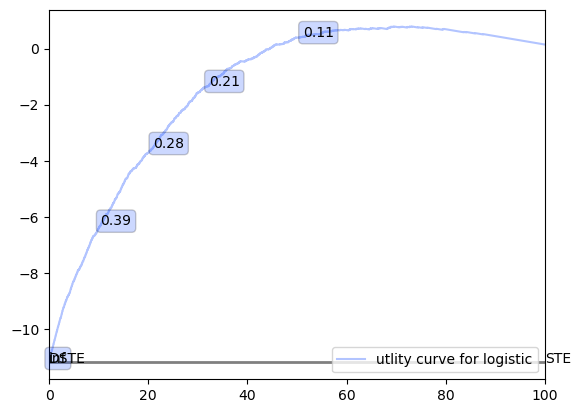

In [58]:
with sns.color_palette("bright"):
    ax=make_profit("logistic",clflog, ytest, Xtest, u, threshold=True, labe=300);
    ax.annotate("DSTE", (0.0, dsteval))
    ax.annotate("STE", (100.0, dsteval))
    plt.plot([0,100],[dsteval,dsteval],'k-', alpha=0.5, lw=2)
    plt.xlim([0,100])

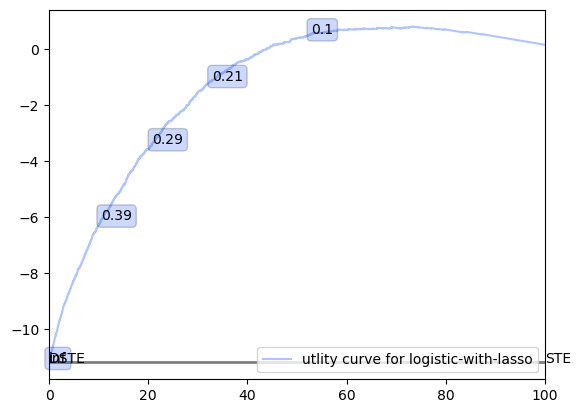

In [59]:
with sns.color_palette("bright"):
    ax=make_profit("logistic-with-lasso",clflog_lasso, ytest, Xtest, u, threshold=True, labe=300);
    ax.annotate("DSTE", (0.0, dsteval))
    ax.annotate("STE", (100.0, dsteval))
    plt.plot([0,100],[dsteval,dsteval],'k-', alpha=0.5, lw=2)
    plt.xlim([0,100])

#### Q7: what range of thresholds do you make a profit for?

Visual Inspection of the Profit Curve
The `make_profit` function plots the curve for the profit at different thresholds (percentage of samples predicted to be positive).
Here's how sample split thresholds are given between training and testing set.
-Look for sections of the curve that are above the baseline profit line (i.e., the line at dsteval, which represents the profit when sending the catalog to none or to everyone).

Identifying Profitable Thresholds
The thresholds of profit are points at which the plotted profit curve rises above the base.
This is something you could actually point out in the graph: where the profit curve is above the dsteval line, this would be showing the thresholds of the population from which you would be reaping more profits due to the implementation of the classifier than baseline strategies of not sending or sending to everyone.
Annotation: "The cats have returned home
The plot is just littered with things like "DSTE" (profit for doing nothing), "STE" (profit for sending to everyone), and so on.
Annotated threshold labels over the curve make it easier to locate exactly the thresholds that give positive profit.
In this respect,
He should read the graph to determine from the plot the set of decision thresholds that minimize loss or maximize profit if the cost ratio and prior odds are known. The lowest and highest bounds define the range of decision thresholds on which the profit curve lies above the baseline. So, in practical application, to maximize the profit, one will choose the set of decision thresholds within this range.
For instance, a curve showing the profits are above a positive threshold between values 0.1 to 0.6; then making your decision threshold within this range will be the optimal threshold for making the highest profitability.
"It
The profit curve will directly show the range of thresholds that produce profit. In other words, you may find the operational thresholds that maximize the financial outcomes for the marketing campaign by investigating the position where it goes above the baseline profit (dsteval). This approach opens up scope for a strategic way of deciding the choice of thresholds based on economic consideration rather than purely statistical metrics, which are important in business applications like direct marketing.


#### Q8: EXTRA CREDIT: experimrnt with some different coupon and marketing costs. Can you increase the profit?

In [60]:
# if you only uses the t as 0.03 it maximize the profit

In [61]:
average_profit_pp(ytest, t_repredict(clflog, 0.03, Xtest), u), \
average_profit_pp(ytest, t_repredict(clflog_lasso, 0.03, Xtest), u),


(0.773561100176303, 0.7616987704201464)

In [62]:
#compared to the orginal

In [63]:
average_profit_pp(ytest, t_repredict(clflog, 0.05, Xtest), u), \
average_profit_pp(ytest, t_repredict(clflog_lasso, 0.05, Xtest), u),


(0.6884032925345899, 0.7271269617435199)